# Model figures for all populations

## Import and define functions
[back to top](#Summarize-models)

In [1]:
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set_style("white")
plt.style.use("huddlej")

In [3]:
mpl.rcParams['savefig.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['font.weight'] = 300
mpl.rcParams['axes.labelweight'] = 300
mpl.rcParams['font.size'] = 18

In [4]:
colors = ['#d73027','#fc8d59','#fee090','#e0f3f8','#91bfdb','#4575b4']

In [5]:
colors.reverse()

In [6]:
colors

['#4575b4', '#91bfdb', '#e0f3f8', '#fee090', '#fc8d59', '#d73027']

In [7]:
ncols = 2
color_by_predictor = {
    'offspring': '#000000',
    'normalized_fitness': '#000000',
    'fitness': '#000000',
    'ep': '#4575b4',
    'ep_wolf': '#4575b4',
    'ep_star': '#4575b4',
    'ep_x': '#4575b4',
    'rb': '#4575b4',
    'cTiter': '#91bfdb',
    'cTiter_x': '#91bfdb',
    'cTiterSub': '#91bfdb',
    'cTiterSub_star': '#91bfdb',
    'cTiterSub_x': '#91bfdb',
    'ne_star': '#999999',
    'dms_star': '#fee090',
    "dms_nonepitope": "#fee090",
    "dms_entropy": "#fee090",
    'unnormalized_lbi': '#fc8d59',
    'lbi': '#fc8d59',
    'delta_frequency': '#d73027'
}

name_by_predictor = {
    "offspring": "observed fitness",
    "normalized_fitness": "true fitness",
    "fitness": "estimated fitness",
    "ep": "epitope mutations",
    "ep_wolf": "Wolf epitope mutations",
    "ep_star": "epitope ancestor",
    "ep_x": "epitope cross-immunity",
    "rb": "Koel epitope mutations",
    "cTiter": "HI tree",
    "cTiter_x": "HI cross-immunity",
    "cTiterSub": "linear HI mut phenotypes",
    "cTiterSub_star": "ancestral HI mut phenotypes",
    "cTiterSub_x": "HI sub cross-immunity",
    "ne_star": "non-epitope mutations",
    "dms_star": "DMS mutational effects",
    "dms_nonepitope": "DMS non-epitope",
    "dms_entropy": "DMS entropy",
    "unnormalized_lbi": "unnormalized LBI",
    "lbi": "LBI",
    "delta_frequency": "delta frequency"
}

predictors_to_drop = [
    #"cTiter-ne_star",
    #"delta_frequency-ne_star",
    #"lbi-ep_x-ne_star"
]

In [8]:
def get_individual_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" not in predictor and predictor != "naive"
    ]

def get_composite_predictors_for_data_frame(df):
    return [
        predictor
        for predictor in df["predictors"].unique()
        if "-" in predictor
    ]

In [98]:
def plot_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="validation_error"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 1.0 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()

    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance\nto future")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.
        distance_ax.plot(
            pd.to_datetime(naive_validation_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_validation_error_df[error_attribute],
            "o-",
            color="#cccccc",
            zorder=-10,
            label="naive (train): %.2f +/- %.2f" % (naive_validation_error_df[error_attribute].mean(), naive_validation_error_df[error_attribute].std())
        )
        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="model (train): %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        validation_legend = distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )

        # Plot test data.
        naive_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(naive_test_error_df["validation_timepoint"]).astype(np.datetime64),
            naive_test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#cccccc",
            zorder=-10,
            label="naive (test): %.2f +/- %.2f" % (naive_test_error_df[error_attribute].mean(), naive_test_error_df[error_attribute].std())
        )
        
        model_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
            test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#000000",
            label="model (test): %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
        )
        
        # Plot legend for test data.
        test_legend = distance_ax.legend(
            handles=[naive_test_distance_handle_output[0], model_test_distance_handle_output[0]],
            loc="upper right",
            frameon=False,
            fontsize=10
        )
        
        # Replot validation data legend, since it is replaced by the test data legend.
        distance_ax.add_artist(validation_legend)

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=10
        )
        
        # Plot validation coefficients
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)        
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

In [159]:
def plot_model_accuracy_and_coefficients_for_build(errors_by_time_df, coefficients_by_time_df, predictors, rotation=30,
                                             years_fmt_string="%Y", date_fmt_string="%Y-%m-%d", height=12, width=12,
                                             text_vertical_padding=0.12, hspace=0.1, wspace=0.2, max_predictor_name_length=55,
                                             share_y=True, max_coefficient=None, max_normal_error=None, error_attribute="model_improvement"):
    # Determine bounds for given data to set axes domains and ranges.
    min_normal_error = errors_by_time_df[error_attribute].min()
    std_normal_error = errors_by_time_df[error_attribute].std()
    min_normal_error -= 0.5 * std_normal_error
    
    if max_normal_error is None:
        max_normal_error = errors_by_time_df[error_attribute].max()
        max_normal_error += 2.0 * std_normal_error

    min_coefficient = coefficients_by_time_df["coefficient"].min()
    
    if max_coefficient is None:
        max_coefficient = coefficients_by_time_df["coefficient"].max() + 2

    min_date = errors_by_time_df["validation_timepoint"].min() - pd.DateOffset(months=6)
    max_date = errors_by_time_df["validation_timepoint"].max() + pd.DateOffset(months=6)
    
    nrows = len(predictors)
    
    naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()
    naive_validation_error_df = naive_error_df[naive_error_df["error_type"] == "validation"].copy()
    naive_test_error_df = naive_error_df[naive_error_df["error_type"] == "test"].copy()
    total_validation_timepoints = naive_validation_error_df.shape[0]
    total_timepoints = naive_error_df.shape[0]
    
    fig, axes = plt.subplots(figsize=(width, height), facecolor='w')
    gs = gridspec.GridSpec(
        nrows=nrows,
        ncols=ncols,
        hspace=hspace,
        wspace=wspace
        #width_ratios=[(total_validation_timepoints + 2) / float(total_timepoints), 1.0]
    )

    years = mdates.YearLocator(3)
    years_fmt = mdates.DateFormatter(years_fmt_string)
    months = mdates.MonthLocator()
    
    # Get the start and end date for test data to enable visual delineation of these later data.
    test_start_date, test_end_date = naive_test_error_df["validation_timepoint"].aggregate(["min", "max"]).values

    for i, predictor in enumerate(predictors):
        error_df = errors_by_time_df[errors_by_time_df["predictors"] == predictor].copy()
        validation_error_df = error_df[error_df["error_type"] == "validation"].copy()
        test_error_df = error_df[error_df["error_type"] == "test"].copy()
        
        coefficient_df = coefficients_by_time_df[coefficients_by_time_df["predictors"] == predictor].copy()
        validation_coefficient_df = coefficient_df[coefficient_df["error_type"] == "validation"].copy()
        test_coefficient_df = coefficient_df[coefficient_df["error_type"] == "test"].copy()
        
        composite_predictors = predictor.split("-")
        composite_predictors_name = " + ".join([name_by_predictor[predictor_name] for predictor_name in composite_predictors])
        if len(composite_predictors_name) > max_predictor_name_length:
            predictor_name_spacing = "\n"
        else:
            predictor_name_spacing = " "

        distance_ax = plt.subplot(gs[i, 1])    
        distance_ax.set_xlabel("Date")
        distance_ax.set_ylabel("Distance closer\nto future (AAs)")

        distance_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation data.        
        distance_ax.plot(
            pd.to_datetime(validation_error_df["validation_timepoint"]).astype(np.datetime64),
            validation_error_df[error_attribute],
            "o-",
            color="#000000",
            label="train: %.2f +/- %.2f" % (validation_error_df[error_attribute].mean(), validation_error_df[error_attribute].std())
        )
        
        # Plot test data.
        model_test_distance_handle_output = distance_ax.plot(
            pd.to_datetime(test_error_df["validation_timepoint"]).astype(np.datetime64),
            test_error_df[error_attribute],
            "o-",
            fillstyle="none",
            color="#000000",
            label="test: %.2f +/- %.2f" % (test_error_df[error_attribute].mean(), test_error_df[error_attribute].std())
        )
        
        distance_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12,
            ncol=2
        )
        
        """# Highlight validation window.
        rectangle = plt.Rectangle(
            (test_start_date, min_normal_error),
            test_end_date - test_start_date,
            max_normal_error - min_normal_error,
            fc='#cccccc',
            alpha=0.5,
            zorder=-10
        )
        distance_ax.add_patch(rectangle)"""

        distance_ax.set_xlim(min_date, max_date)
        
        distance_ax.set_ylim(min_normal_error, max_normal_error)
        #distance_ax.set_ylim(0, max_normal_error + std_normal_error / 2)
        distance_ax.xaxis.set_major_locator(years)
        distance_ax.xaxis.set_major_formatter(years_fmt)
        distance_ax.xaxis.set_minor_locator(months)
        distance_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

        coefficient_ax = plt.subplot(gs[i, 0])
        coefficient_ax.set_xlabel("Date")
        coefficient_ax.set_ylabel("Coefficient")
        
        if share_y:
            coefficient_ax.set_ylim(min_coefficient - 1, max_coefficient)

        coefficient_ax.axhline(
            y=0.0,
            color="#cccccc"
        )

        # Plot validation coefficients
        for predictor, predictor_coefficient_df in validation_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )
            
        coefficient_ax.legend(
            loc="upper left",
            frameon=False,
            fontsize=12
        )

        # Plot fixed coefficients for testing
        for predictor, predictor_coefficient_df in test_coefficient_df.groupby("predictor"):
            coefficient_ax.plot(
                predictor_coefficient_df["validation_timepoint"],
                predictor_coefficient_df["coefficient"],
                "o-",
                fillstyle="none",
                color=color_by_predictor[predictor],
                label="%s: %.2f +/- %.2f" % (
                    name_by_predictor[predictor],
                    predictor_coefficient_df["coefficient"].mean(),
                    predictor_coefficient_df["coefficient"].std()
                )
            )

        coefficient_ax.set_xlim(min_date, max_date)
        coefficient_ax.xaxis.set_major_locator(years)
        coefficient_ax.xaxis.set_major_formatter(years_fmt)
        coefficient_ax.xaxis.set_minor_locator(months)
        coefficient_ax.format_xdata = mdates.DateFormatter(date_fmt_string)

    fig.autofmt_xdate(rotation=rotation, ha="center")
    gs.tight_layout(fig, h_pad=hspace)
    # show x-axis tick lines
    
    return (fig, axes, gs)

## Load data

In [38]:
simulated_sample = "simulated_sample_3"
natural_sample = "natural_sample_0_with_90_vpm_sliding"
luksza_sample = "luksza_lassig"

In [39]:
errors_file = "../results/distance_model_errors.tsv"
coefficients_file = "../results/distance_model_coefficients.tsv"

In [40]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])

In [41]:
errors_by_time_df["sample"].unique()

array(['simulated_sample_3'], dtype=object)

In [100]:
errors_by_time_df = pd.read_csv(errors_file, sep="\t", parse_dates=["validation_timepoint"])
errors_by_time_df = errors_by_time_df[~errors_by_time_df["predictors"].isin(predictors_to_drop)].copy()
errors_by_time_df["model_improvement"] = errors_by_time_df["null_validation_error"] - errors_by_time_df["validation_error"]

simulated_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == simulated_sample].copy()
natural_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == natural_sample].copy()
luksza_errors_by_time_df = errors_by_time_df[errors_by_time_df["sample"] == luksza_sample].copy()

In [101]:
simulated_errors_by_time_df.shape

(416, 9)

In [102]:
natural_errors_by_time_df.shape

(0, 9)

In [103]:
luksza_errors_by_time_df.shape

(0, 9)

In [104]:
coefficients_by_time_df = pd.read_csv(coefficients_file, sep="\t", parse_dates=["validation_timepoint"])
coefficients_by_time_df = coefficients_by_time_df[~coefficients_by_time_df["predictors"].isin(predictors_to_drop)].copy()

simulated_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == simulated_sample].copy()
natural_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == natural_sample].copy()
luksza_coefficients_by_time_df = coefficients_by_time_df[coefficients_by_time_df["sample"] == luksza_sample].copy()

In [105]:
simulated_coefficients_by_time_df.shape

(520, 7)

In [106]:
natural_coefficients_by_time_df.shape

(0, 7)

In [107]:
luksza_coefficients_by_time_df.shape

(0, 7)

In [108]:
get_individual_predictors_for_data_frame(simulated_errors_by_time_df)

['normalized_fitness', 'ep_x', 'ne_star', 'lbi', 'delta_frequency']

In [109]:
get_individual_predictors_for_data_frame(natural_errors_by_time_df)

[]

In [110]:
simulated_errors_by_time_df.tail()

,null_validation_error,predictors,validation_error,validation_n,validation_timepoint,type,sample,error_type,model_improvement
411,11.732285,lbi-ne_star,8.011018,630,2047-10-01,simulated,simulated_sample_3,test,3.721268
412,10.930322,lbi-ne_star,9.222836,630,2048-04-01,simulated,simulated_sample_3,test,1.707486
413,7.422700,lbi-ne_star,6.038409,630,2048-10-01,simulated,simulated_sample_3,test,1.384291
414,7.478334,lbi-ne_star,6.958540,630,2049-04-01,simulated,simulated_sample_3,test,0.519794
415,7.239005,lbi-ne_star,6.338629,630,2049-10-01,simulated,simulated_sample_3,test,0.900376


## Distance to the future

### Simulated populations

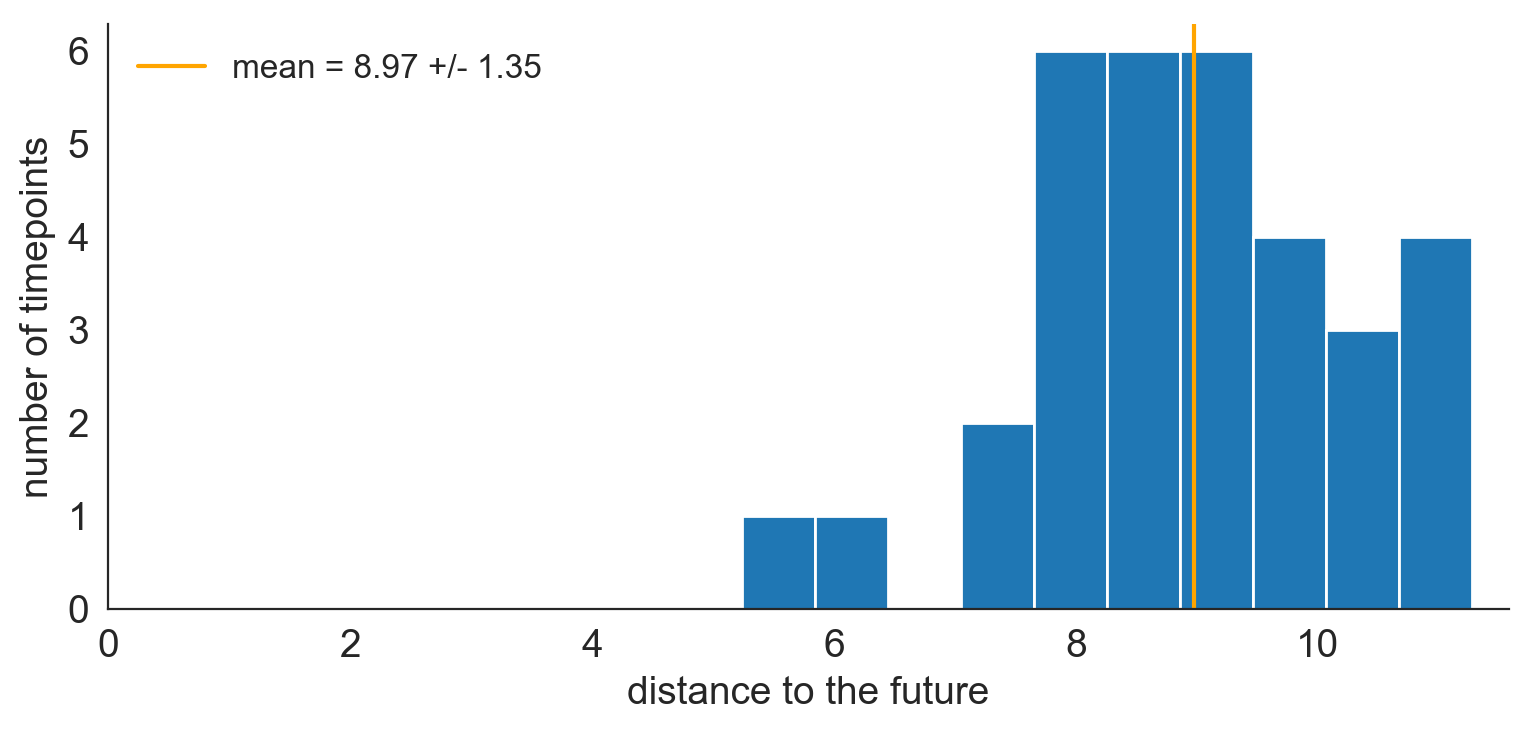

In [29]:
naive_simulated_validation_set = (
    (simulated_errors_by_time_df["predictors"] == "naive") & (simulated_errors_by_time_df["error_type"] == "validation")
)
naive_simulated_errors_by_time_df = simulated_errors_by_time_df[naive_simulated_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_simulated_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_simulated_errors_by_time_df.mean()
std_y = naive_simulated_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-simulated-populations-between-timepoints.png")

### Natural populations

In [ ]:
naive_natural_validation_set = (
    (natural_errors_by_time_df["predictors"] == "naive") & (natural_errors_by_time_df["error_type"] == "validation")
)
naive_natural_errors_by_time_df = natural_errors_by_time_df[naive_natural_validation_set]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.hist(naive_natural_errors_by_time_df, bins=10, label=None)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_natural_errors_by_time_df.mean()
std_y = naive_natural_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange",
    label="mean = %.2f +/- %.2f" % (mean_y, std_y)
)
ax.legend(
    frameon=False
)
ax.set_xlim(left=0)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-natural-populations-between-timepoints.png")

### Luksza and Lassig populations

In [ ]:
naive_luksza_errors_by_time_df = luksza_errors_by_time_df[luksza_errors_by_time_df["predictors"] == "naive"]["validation_error"]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.hist(naive_luksza_errors_by_time_df, bins=10)
ax.set_xlabel("distance to the future")
ax.set_ylabel("number of timepoints")

mean_y = naive_luksza_errors_by_time_df.mean()
std_y = naive_luksza_errors_by_time_df.std()
ax.axvline(
    x=mean_y,
    color="orange"
)

ax.text(
    0.5,
    0.8,
    "mean = %.2f +/- %.2f" % (mean_y, std_y),
    transform=ax.transAxes,
    fontsize=12,
    horizontalalignment="left"
)

plt.tight_layout()
plt.savefig("../manuscript/figures/distance-of-luksza-lassig-populations-between-timepoints.png")

## Figure 2: Summary of models for simulated populations

In [57]:
simulated_errors_by_time_df["model"] = simulated_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [54]:
simulated_errors_by_time_df["model_minus_naive"] = (
    simulated_errors_by_time_df["validation_error"] - simulated_errors_by_time_df["null_validation_error"]
)

simulated_errors_by_time_df["model_better_than_naive"] = (simulated_errors_by_time_df["model_minus_naive"] < 0)

simulated_errors_by_time_df["relative_improvement"] = (
    simulated_errors_by_time_df["validation_error"] / simulated_errors_by_time_df["null_validation_error"]
) - 1.0

In [55]:
simulated_errors_by_time_df.head()

,null_validation_error,predictors,validation_error,validation_n,validation_timepoint,type,sample,error_type,model_minus_naive,model_better_than_naive,relative_improvement
0,8.870808,naive,8.870808,630,2023-10-01,simulated,simulated_sample_3,validation,0.0,False,0.0
1,8.351673,naive,8.351673,630,2024-04-01,simulated,simulated_sample_3,validation,0.0,False,0.0
2,10.027961,naive,10.027961,630,2024-10-01,simulated,simulated_sample_3,validation,0.0,False,0.0
3,11.031343,naive,11.031343,630,2025-04-01,simulated,simulated_sample_3,validation,0.0,False,0.0
4,8.814196,naive,8.814196,630,2025-10-01,simulated,simulated_sample_3,validation,0.0,False,0.0


In [64]:
simulated_errors_by_time_df.groupby(["model", "error_type"]).aggregate({
    "model_minus_naive": ["mean", "std"],
    "model_better_than_naive": ["sum", "mean"]
}).reset_index().sort_values(["error_type", ""])

model  error_type  \
                                                                 
0                                              LBI        test   
1                                              LBI  validation   
2                      LBI + non-epitope mutations        test   
3                      LBI + non-epitope mutations  validation   
4                                  delta frequency        test   
5                                  delta frequency  validation   
6                           epitope cross-immunity        test   
7                           epitope cross-immunity  validation   
8   epitope cross-immunity + non-epitope mutations        test   
9   epitope cross-immunity + non-epitope mutations  validation   
10                                           naive        test   
11                                           naive  validation   
12                           non-epitope mutations        test   
13                           non-epitope mutations  validation   
14                                    true fitness        test   
15                                    true fitness  validation   

   model_minus_naive           model_better_than_naive            
                mean       std                     sum      mean  
0          -1.252222  1.548620                    16.0  0.842105  
1          -1.405038  1.304089                    29.0  0.878788  
2          -1.691703  1.279632                    18.0  0.947368  
3          -1.736730  1.016402                    32.0  0.969697  
4          -0.382068  0.994077                    14.0  0.736842  
5          -0.845624  0.920962                    26.0  0.787879  
6          -0.001716  0.015936                    13.0  0.684211  
7          -0.002540  0.028830                    18.0  0.545455  
8          -0.936639  0.617931                    16.0  0.842105  
9          -0.702380  0.598875                    28.0  0.848485  
10          0.000000  0.000000                     0.0  0.000000  
11          0.000000  0.000000                     0.0  0.000000  
12         -0.916320  0.498134                    19.0  1.000000  
13         -0.706760  0.575173                    29.0  0.878788  
14         -1.582704  1.039618                    17.0  0.894737  
15         -2.157539  1.185171                    32.0  0.969697

In [68]:
simulated_model_selection = simulated_errors_by_time_df.groupby(["model", "error_type"]).aggregate({
    "model_minus_naive": ["mean", "std"],
    "model_better_than_naive": ["sum", "mean"]
}).sort_values(["error_type", ("model_minus_naive", "mean")])

simulated_model_selection.loc[:, ("model_better_than_naive", "sum")] = simulated_model_selection[("model_better_than_naive", "sum")].astype(int)

In [69]:
simulated_model_selection

model_minus_naive  \
                                                                       mean   
model                                          error_type                     
LBI + non-epitope mutations                    test               -1.691703   
true fitness                                   test               -1.582704   
LBI                                            test               -1.252222   
epitope cross-immunity + non-epitope mutations test               -0.936639   
non-epitope mutations                          test               -0.916320   
delta frequency                                test               -0.382068   
epitope cross-immunity                         test               -0.001716   
naive                                          test                0.000000   
true fitness                                   validation         -2.157539   
LBI + non-epitope mutations                    validation         -1.736730   
LBI                                            validation         -1.405038   
delta frequency                                validation         -0.845624   
non-epitope mutations                          validation         -0.706760   
epitope cross-immunity + non-epitope mutations validation         -0.702380   
epitope cross-immunity                         validation         -0.002540   
naive                                          validation          0.000000   

                                                                     \
                                                                std   
model                                          error_type             
LBI + non-epitope mutations                    test        1.279632   
true fitness                                   test        1.039618   
LBI                                            test        1.548620   
epitope cross-immunity + non-epitope mutations test        0.617931   
non-epitope mutations                          test        0.498134   
delta frequency                                test        0.994077   
epitope cross-immunity                         test        0.015936   
naive                                          test        0.000000   
true fitness                                   validation  1.185171   
LBI + non-epitope mutations                    validation  1.016402   
LBI                                            validation  1.304089   
delta frequency                                validation  0.920962   
non-epitope mutations                          validation  0.575173   
epitope cross-immunity + non-epitope mutations validation  0.598875   
epitope cross-immunity                         validation  0.028830   
naive                                          validation  0.000000   

                                                          model_better_than_naive  \
                                                                              sum   
model                                          error_type                           
LBI + non-epitope mutations                    test                            18   
true fitness                                   test                            17   
LBI                                            test                            16   
epitope cross-immunity + non-epitope mutations test                            16   
non-epitope mutations                          test                            19   
delta frequency                                test                            14   
epitope cross-immunity                         test                            13   
naive                                          test                             0   
true fitness                                   validation                      32   
LBI + non-epitope mutations                    validation                      32   
LBI                                            validation                      29   
delta frequency 

In [ ]:
simulated_model_selection_table = simulated_model_selection.to_latex(
    float_format="%.2f"
)

with open("../manuscript/tables/simulated_model_selection.tex", "w") as oh:
    oh.write(simulated_model_selection_table)

In [ ]:
simulated_errors_by_time_df.head(1)

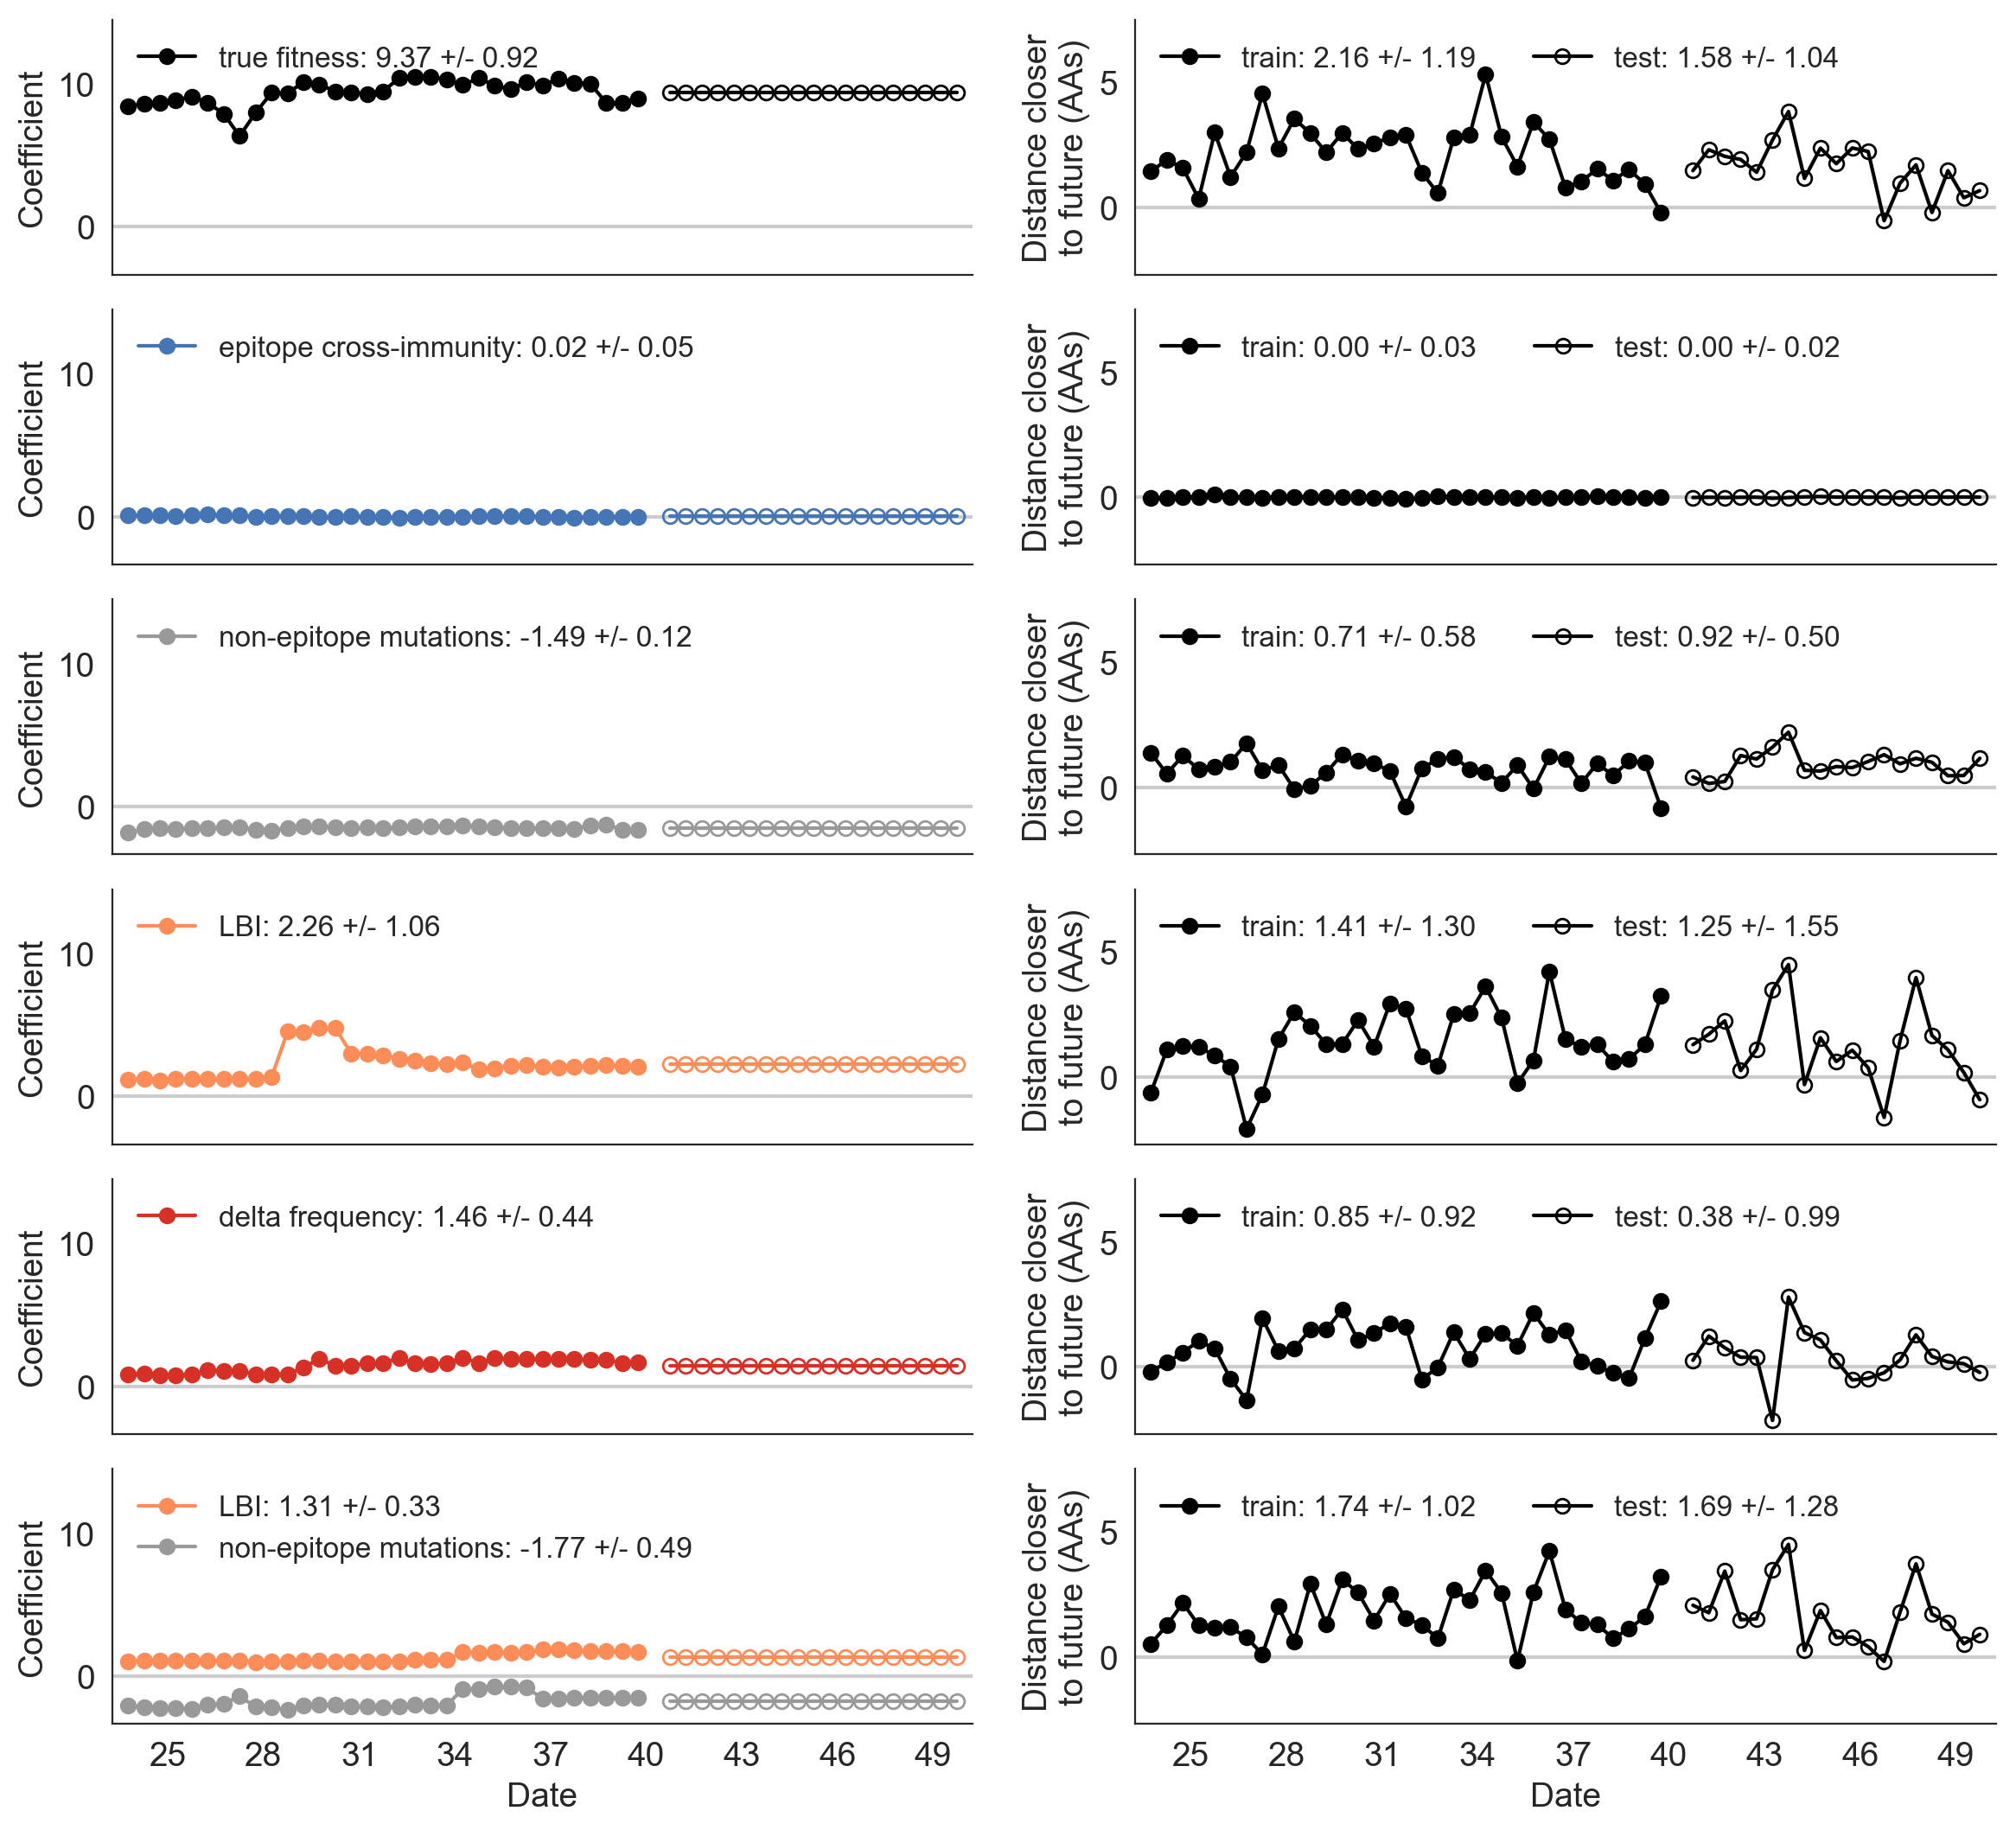

In [161]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(simulated_errors_by_time_df) + ["lbi-ne_star"],
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=11,
    hspace=0.1,
    share_y=True,
    max_coefficient=14.5
#    max_normal_error=10
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-simulated-populations.png")

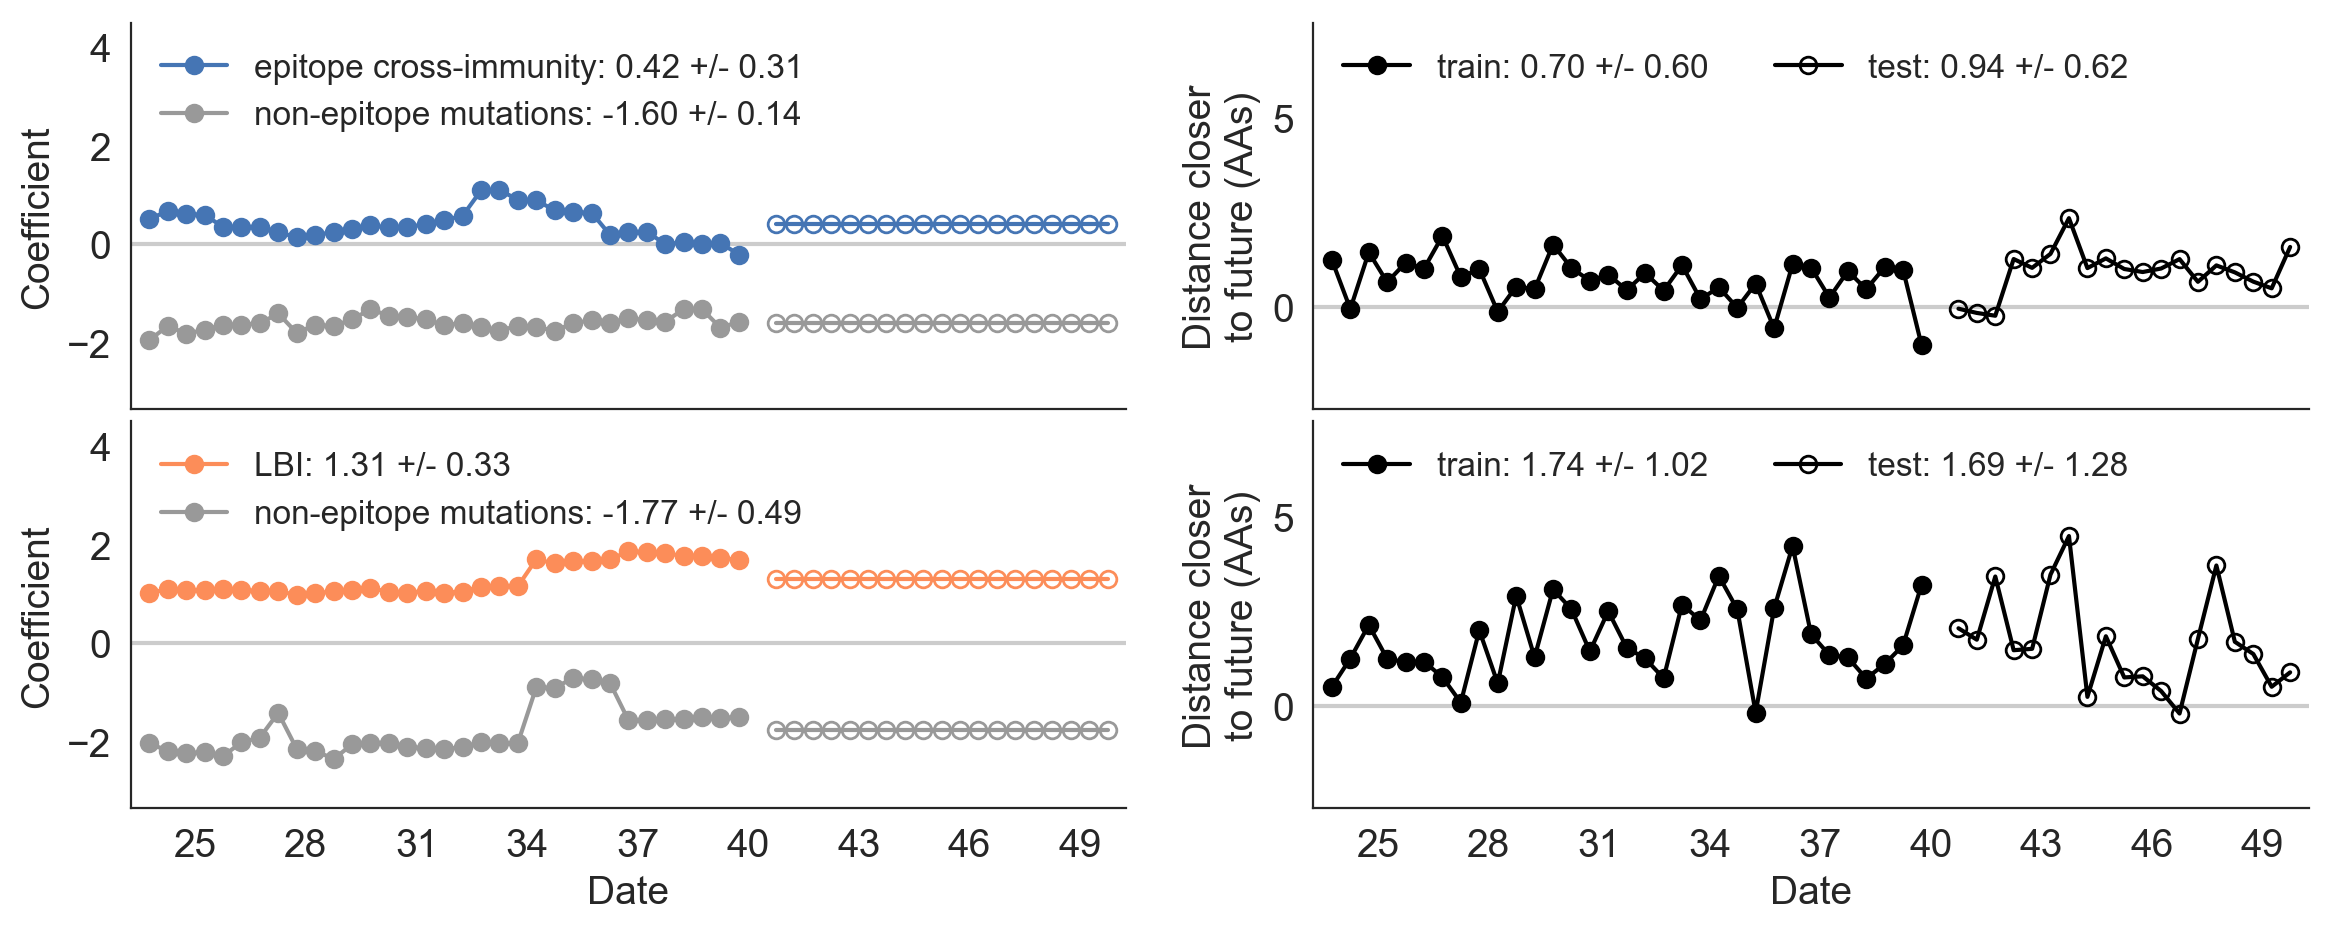

In [160]:
fig, axes, gs = plot_model_accuracy_and_coefficients_for_build(
    simulated_errors_by_time_df,
    simulated_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(simulated_errors_by_time_df),
    rotation=0,
    years_fmt_string="%y",
    date_fmt_string="%y-%m",
    height=5,
    max_coefficient=4.5
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-simulated-populations.png")

## Figure 3: Summary of models for natural populations

In [ ]:
natural_errors_by_time_df["validation_timepoint"].unique().shape

In [ ]:
natural_errors_by_time_df["model"] = natural_errors_by_time_df["predictors"].apply(
    lambda predictor: " + ".join([name_by_predictor.get(predictor_name, predictor_name) for predictor_name in predictor.split("-")])
)

In [ ]:
naive_natural_errors_by_time_df = natural_errors_by_time_df.query("predictors == 'naive'").copy()

In [ ]:
natural_errors_by_time_df = natural_errors_by_time_df.merge(
    naive_natural_errors_by_time_df,
    on=["sample", "type", "validation_timepoint", "validation_n"],
    suffixes=["", "_naive"]
)

In [ ]:
natural_errors_by_time_df.head()

In [ ]:
natural_errors_by_time_df["model_minus_naive"] = (
    natural_errors_by_time_df["validation_error"] - natural_errors_by_time_df["validation_error_naive"]
)

natural_errors_by_time_df["model_better_than_naive"] = (natural_errors_by_time_df["model_minus_naive"] < 0)

natural_errors_by_time_df["relative_improvement"] = (
    natural_errors_by_time_df["validation_error"] / natural_errors_by_time_df["validation_error_naive"]
) - 1.0

In [ ]:
natural_model_selection = natural_errors_by_time_df.groupby("model").aggregate({
    "model_minus_naive": ["mean"],
    "model_better_than_naive": ["sum", "mean"]
}).sort_values(("model_minus_naive", "mean"))

natural_model_selection.loc[:, ("model_better_than_naive", "sum")] = natural_model_selection[("model_better_than_naive", "sum")].astype(int)

In [ ]:
natural_model_selection

In [ ]:
natural_model_selection_table = natural_model_selection.to_latex(
    float_format="%.2f"
)

with open("../manuscript/tables/natural_model_selection.tex", "w") as oh:
    oh.write(natural_model_selection_table)

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(natural_errors_by_time_df),
    height=20,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations-all-individual-predictors.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    get_composite_predictors_for_data_frame(natural_errors_by_time_df),
    height=7,
    rotation=0
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-natural-populations-all-composite-predictors.png")

### Individual models

In [ ]:
subset_of_individual_predictors = [
    "ep_x",
    "cTiter_x",
    "ne_star",
    "dms_star",
    "lbi",
    "delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    subset_of_individual_predictors,
    height=9,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Within category model comparisons

#### Antigenic

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["ep", "ep_x", "ep_wolf", "rb"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-epitope-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["cTiter", "cTiter_x", "cTiterSub", "cTiterSub_x"],
    height=8,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-HI-model-accuracy-and-coefficients-for-natural-populations.png")

#### Functional

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    ["dms_star", "dms_entropy", "dms_nonepitope", "ne_star"],
    height=6,
    rotation=0
)
plt.savefig("../manuscript/figures/unadjusted-DMS-model-accuracy-and-coefficients-for-natural-populations.png")

#### All categories

In [ ]:
within_category_composite_predictors = [
    "ep_x-cTiter_x",
    "ne_star-dms_star",
    "lbi-delta_frequency"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    within_category_composite_predictors,
    height=6,
    text_vertical_padding=0.15
)
plt.savefig("../manuscript/figures/within-category-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Composite models

In [ ]:
composite_models = [
    "cTiter_x-ne_star",
    "ne_star-lbi",
    "cTiter_x-ne_star-lbi"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    composite_models,
    height=6,
    text_vertical_padding=0.12,
    max_coefficient=6,
    rotation=0
)
plt.savefig("../manuscript/figures/best-composite-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

### Best three-metric composite models

In [ ]:
best_three_metric_model = [
    "lbi-cTiter_x-ne_star",
    "delta_frequency-cTiter_x-ne_star"
]

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    natural_errors_by_time_df,
    natural_coefficients_by_time_df,
    best_three_metric_model,
    height=5
)
#plt.savefig("../manuscript/figures/best-three-metric-unadjusted-model-accuracy-and-coefficients-for-natural-populations.png")

In [ ]:
naive_error_df.head()

In [ ]:
naive_error_df.tail()

Calculate sum of differences between the estimated distances from the naive model and each biological model. The higher sum per model, the more the biological model outperforms the naive model.

In [ ]:
naive_error_df = errors_by_time_df[errors_by_time_df["predictors"] == "naive"].copy()

In [ ]:
natural_errors_by_time_with_naive_df = natural_errors_by_time_df.merge(
    naive_error_df,
    on=["validation_timepoint", "validation_n", "type", "sample"],
    suffixes=["_model", "_naive"]
)

In [ ]:
natural_errors_by_time_with_naive_df["model_gain"] = (
    natural_errors_by_time_with_naive_df["validation_error_naive"] - natural_errors_by_time_with_naive_df["validation_error_model"]
)

In [ ]:
natural_errors_by_time_with_naive_df.head()

In [ ]:
natural_errors_by_time_with_naive_df.groupby("predictors_model")["model_gain"].sum().sort_values(ascending=False)

## Figure 4: Summary of models for Luksza and Lassig populations

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    get_individual_predictors_for_data_frame(luksza_errors_by_time_df),
    height=6
)
#plt.savefig("../manuscript/figures/unadjusted-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")

In [ ]:
fig, axes, gs = plot_accuracy_and_coefficients_for_build(
    luksza_errors_by_time_df,
    luksza_coefficients_by_time_df,
    ["lbi", "ep_x", "ne_star"] + get_composite_predictors_for_data_frame(luksza_errors_by_time_df)
)
#plt.savefig("../manuscript/figures/unadjusted-composite-model-accuracy-and-coefficients-for-luksza-lassig-populations.png")